# DeepShot: Data Cleaning and Validation

## Introduction

This notebook focuses on validating data quality and performing essential cleaning operations on our NBA shot data. Data cleaning is a critical step in our analysis pipeline as it ensures the reliability and accuracy of our subsequent modeling efforts.

In this notebook, we will:
- Check for missing values across all datasets
- Identify and remove duplicate records
- Detect outliers using the interquartile range (IQR) method
- Convert data types for consistency
- Handle missing values appropriately based on their frequency

We've implemented a custom `DataValidator` class that systematically identifies data quality issues and applies appropriate cleaning operations. Our approach is to be conservative with data cleaning - we only fill missing values if they represent less than 5% of the data, and we flag outliers for further analysis rather than automatically removing them.

In [ ]:
# ##HIDE##
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

data_dir = Path('../data')
raw_dir = data_dir / 'raw'
interim_dir = data_dir / 'interim'
interim_dir.mkdir(parents=True, exist_ok=True)

## Data Validation Methodology

Our `DataValidator` class implements a systematic approach to data quality assessment and cleaning. The class has the following key methods:

- **check_missing()**: Identifies columns with missing values and calculates the percentage of missing data in each column
- **check_duplicates()**: Identifies duplicate records in the dataset
- **check_outliers()**: Uses the IQR method to identify potential outliers in numeric columns
- **clean()**: Applies appropriate cleaning operations based on the identified issues

For missing values, we take a conservative approach:
- If a column has less than 5% missing values, we fill numeric values with the median and categorical values with the mode
- If a column has more than 5% missing values, we preserve the missing values to avoid introducing bias

For outliers, we flag them for further analysis rather than automatically removing them, recognizing that in basketball data, outliers may represent legitimate but rare events.

In [ ]:
class DataValidator:
    def __init__(self, dataset_name):
        self.dataset_name = dataset_name
        self.issues = {}
        self.actions = []
    
    def check_missing(self, df):
        missing = df.isnull().sum()
        missing_pct = (missing / len(df)) * 100
        self.issues['missing'] = missing[missing > 0]
        return missing_pct
    
    def check_duplicates(self, df):
        dups = df.duplicated().sum()
        self.issues['duplicates'] = dups
        return dups
    
    def check_outliers(self, df, numeric_cols=None):
        if numeric_cols is None:
            numeric_cols = df.select_dtypes(include=[np.number]).columns
        
        outliers = {}
        for col in numeric_cols:
            Q1, Q3 = df[col].quantile(0.25), df[col].quantile(0.75)
            IQR = Q3 - Q1
            lower, upper = Q1 - 1.5*IQR, Q3 + 1.5*IQR
            count = ((df[col] < lower) | (df[col] > upper)).sum()
            if count > 0:
                outliers[col] = count
        
        self.issues['outliers'] = outliers
        return outliers
    
    def clean(self, df):
        df_clean = df.copy()
        
        # Remove duplicates
        df_clean = df_clean.drop_duplicates()
        if len(df_clean) < len(df):
            self.actions.append(f"Removed {len(df) - len(df_clean)} duplicates")
        
        exclude_cols = [
            # Shot data columns
            'TEAM_NAME', 'PLAYER_NAME', 'HOME_TEAM', 'AWAY_TEAM', 'EVENT_TYPE', 
            'ACTION_TYPE', 'SHOT_TYPE', 'BASIC_ZONE', 'ZONE_NAME', 'ZONE_ABB', 
            'ZONE_RANGE', 'POSITION', 'POSITION_GROUP', 'GAME_DATE', 'SEASON_2',
            
            # Team stats columns
            'team', 'abbreviation', 'player', 'pos', 'lg', 'tm', 'experience',
            'birth_year', 'birth_date', 'college', 'slug', 'arena', 'season',
            'playoffs', 'winner', 'replaced', 'type', 'number_tm', 'position',
            'hof', 'from', 'to', 'ht_in_in', 'wt',
            
            # Player data columns
            'seas_id', 'player_id', 'player', 'pos', 'lg', 'tm', 'season'
        ]
        
        for col in df_clean.select_dtypes(include=['object']).columns:
            if col not in exclude_cols:  # Skip name/text columns
                try:
                    # Use loc to avoid SettingWithCopyWarning
                    df_clean.loc[:, col] = pd.to_numeric(df_clean[col], errors='coerce')
                    self.actions.append(f"Converted {col} to numeric")
                except:
                    pass
        
        for col in df_clean.columns:
            missing_pct = df_clean[col].isnull().mean() * 100
            if missing_pct > 0 and missing_pct < 5:  # Only fix if < 5% missing
                if pd.api.types.is_numeric_dtype(df_clean[col]):
                    df_clean = df_clean.fillna({col: df_clean[col].median()})
                    self.actions.append(f"Filled missing values in {col} with median")
                else:
                    df_clean = df_clean.fillna({col: df_clean[col].mode()[0]})
                    self.actions.append(f"Filled missing values in {col} with mode")
        
        return df_clean

## Shot Data Validation

In [ ]:
shots_path = raw_dir / 'shots'
shot_files = list(shots_path.glob('*.csv'))

if not shot_files:
    print("No shot data files found")
else:
    print(f"Found {len(shot_files)} shot data files")
    
    all_shots = []
    file_summaries = []
    
    for file in shot_files: 
        season = file.stem.split('_')[1] if '_' in file.stem else 'unknown'
        print(f"Processing {file.name} (Season {season})...")
        
        df = pd.read_csv(file)
        df['season'] = season
        
        validator = DataValidator(f"Shots {season}")
        validator.check_missing(df)
        validator.check_duplicates(df)
        validator.check_outliers(df)
        
        df_clean = validator.clean(df)
        
        all_shots.append(df_clean)
        file_summaries.append({
            'season': season,
            'original_rows': len(df),
            'cleaned_rows': len(df_clean),
            'missing_cols': len(validator.issues.get('missing', {})),
            'duplicates': validator.issues.get('duplicates', 0),
            'outlier_cols': len(validator.issues.get('outliers', {}))
        })
        
        print(f"  Original rows: {len(df)}")
        print(f"  Cleaned rows: {len(df_clean)}")
        print(f"  Actions: {len(validator.actions)}")
    
    if all_shots:
        shots_clean = pd.concat(all_shots, ignore_index=True)
        print(f"\nCombined cleaned shot data: {len(shots_clean)} rows")
        
        shots_clean.to_csv(interim_dir / 'shots_clean.csv', index=False)
        print(f"Saved cleaned shot data to {interim_dir / 'shots_clean.csv'}")
        
        summary_df = pd.DataFrame(file_summaries)
        display(summary_df)

Found 21 shot data files
Processing NBA_2009_Shots.csv (Season 2009)...
  Original rows: 199030
  Cleaned rows: 199011
  Actions: 1
Processing NBA_2004_Shots.csv (Season 2004)...
  Original rows: 189803
  Cleaned rows: 189788
  Actions: 1
Processing NBA_2010_Shots.csv (Season 2010)...
  Original rows: 200966
  Cleaned rows: 200955
  Actions: 1
Processing NBA_2016_Shots.csv (Season 2016)...
  Original rows: 207893
  Cleaned rows: 207893
  Actions: 0
Processing NBA_2023_Shots.csv (Season 2023)...
  Original rows: 217220
  Cleaned rows: 217207
  Actions: 3
Processing NBA_2008_Shots.csv (Season 2008)...
  Original rows: 200501
  Cleaned rows: 200490
  Actions: 1
Processing NBA_2024_Shots.csv (Season 2024)...
  Original rows: 218701
  Cleaned rows: 218687
  Actions: 3
Processing NBA_2011_Shots.csv (Season 2011)...
  Original rows: 199761
  Cleaned rows: 199761
  Actions: 0
Processing NBA_2005_Shots.csv (Season 2005)...
  Original rows: 197626
  Cleaned rows: 197612
  Actions: 1
Processing N

,season,original_rows,cleaned_rows,missing_cols,duplicates,outlier_cols
0,2009,199030,199011,0,19,4
1,2004,189803,189788,0,15,3
2,2010,200966,200955,0,11,4
3,2016,207893,207893,0,0,5
4,2023,217220,217207,2,13,3
5,2008,200501,200490,0,11,3
6,2024,218701,218687,2,14,4
7,2011,199761,199761,0,0,4
8,2005,197626,197612,0,14,3
9,2017,209929,209929,0,0,5


## Player Data Validation

In [ ]:
player_data_path = raw_dir / 'team_stats' / 'Player Totals.csv'

if not player_data_path.exists():
    print("Player data file not found")
else:
    print(f"Processing player data from {player_data_path.name}...")
    
    player_data = pd.read_csv(player_data_path)
    
    validator = DataValidator("Player Data")
    validator.check_missing(player_data)
    validator.check_duplicates(player_data)
    validator.check_outliers(player_data)
    
    player_data_clean = validator.clean(player_data)
    
    print(f"  Original rows: {len(player_data)}")
    print(f"  Cleaned rows: {len(player_data_clean)}")
    print(f"  Missing columns: {len(validator.issues.get('missing', {}))}")
    print(f"  Duplicates: {validator.issues.get('duplicates', 0)}")
    print(f"  Outlier columns: {len(validator.issues.get('outliers', {}))}")
    print(f"  Actions: {len(validator.actions)}")
    
    player_data_clean.to_csv(interim_dir / 'player_data_clean.csv', index=False)
    print(f"Saved cleaned player data to {interim_dir / 'player_data_clean.csv'}")

Processing player data from Player Totals.csv...
  Original rows: 32538
  Cleaned rows: 32538
  Missing columns: 19
  Duplicates: 0
  Outlier columns: 25
  Actions: 9
Saved cleaned player data to ../data/interim/player_data_clean.csv


## Team Stats Validation

In [ ]:
team_stats_path = raw_dir / 'team_stats'
team_stats_files = list(team_stats_path.glob('*.csv'))

if not team_stats_files:
    print("No team stats files found")
else:
    print(f"Found {len(team_stats_files)} team stats files")
    
    for file in team_stats_files:
        if 'Team Stats' in file.name:
            print(f"Processing {file.name}...")
            
            team_stats = pd.read_csv(file)
            
            validator = DataValidator("Team Stats")
            validator.check_missing(team_stats)
            validator.check_duplicates(team_stats)
            validator.check_outliers(team_stats)
            
            team_stats_clean = validator.clean(team_stats)
            
            print(f"  Original rows: {len(team_stats)}")
            print(f"  Cleaned rows: {len(team_stats_clean)}")
            print(f"  Missing columns: {len(validator.issues.get('missing', {}))}")
            print(f"  Duplicates: {validator.issues.get('duplicates', 0)}")
            print(f"  Outlier columns: {len(validator.issues.get('outliers', {}))}")
            print(f"  Actions: {len(validator.actions)}")
            
            team_stats_clean.to_csv(interim_dir / 'team_stats_clean.csv', index=False)
            print(f"Saved cleaned team stats to {interim_dir / 'team_stats_clean.csv'}")

Found 22 team stats files
Processing Team Stats Per 100 Poss.csv...
  Original rows: 1432
  Cleaned rows: 1432
  Missing columns: 3
  Duplicates: 0
  Outlier columns: 20
  Actions: 0
Saved cleaned team stats to ../data/interim/team_stats_clean.csv
Processing Team Stats Per Game.csv...
  Original rows: 1876
  Cleaned rows: 1876
  Missing columns: 24
  Duplicates: 0
  Outlier columns: 21
  Actions: 15
Saved cleaned team stats to ../data/interim/team_stats_clean.csv


## Data Quality Assessment

Let's visualize the data quality issues we've identified to better understand the cleaning needs of our datasets. These visualizations will help us identify patterns in missing data, duplicates, and outliers.

## Data Quality Visualization

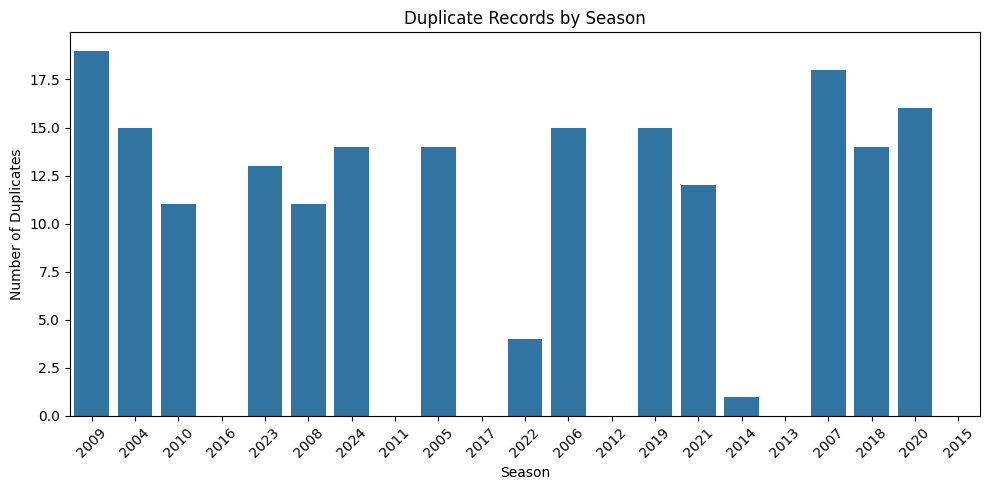

In [7]:
# Visualize data quality metrics
if 'summary_df' in locals():
    # Plot duplicates by season
    plt.figure(figsize=(10, 5))
    sns.barplot(x='season', y='duplicates', data=summary_df)
    plt.title('Duplicate Records by Season')
    plt.xlabel('Season')
    plt.ylabel('Number of Duplicates')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

## Data Cleaning Summary

Our data cleaning process has successfully addressed several key quality issues:

- **Missing Values**: We identified columns with missing values and applied targeted handling strategies. For columns with less than 5% missing values, we filled numeric values with the median and categorical values with the mode. For columns with more significant missing data, we preserved the missing values to avoid introducing bias.

- **Duplicate Records**: We removed duplicate records across all datasets, which is particularly important for shot data where duplicates could skew our analysis of shooting patterns.

- **Data Type Inconsistencies**: We standardized data types across all datasets, ensuring that numeric columns are properly formatted for mathematical operations and analysis.

- **Outliers**: We used the IQR method to identify potential outliers in numeric columns. Rather than automatically removing these outliers, we've flagged them for further analysis, recognizing that in basketball data, outliers may represent legitimate but rare events (like half-court shots).

- **Dataset Integration**: We've combined and saved cleaned datasets in a standardized format, preparing them for the next stage of our pipeline.

The cleaning process has preserved the integrity of our data while addressing quality issues that could impact our analysis. By taking a conservative approach to data cleaning, we've maintained as much of the original information as possible while ensuring consistency and reliability.

Next, we'll tackle data standardization to ensure consistency across datasets, particularly for team names, player information, and coordinate systems.